# 3D Cone beam reconstruction with Astra toolbox
Notebook author: Peter Winkel Rasmussen (pwra@dtu.dk)

This is the simplest scripts for a vector based cone beam reconstruction with the ASTRA Toolbox. The script is setup to use the FDK (FBP) algorithm for the reconstruction with GPU enabled.
The reconstruction requries several geometrical parameters:
* `C_l` is the camera length i.e the distance between the X-ray source and the detector.
* `S_u` is the horizontal between offset the middle of the X-ray cone and the middle of the X-ray detector. It it probably zero for a well calibrated CT scanner.
* `D_u` is the horizontal offset between the sample and the axis of rotation. The quality of the reconstruction depends heavily on this parameter being set correctly. It is rarely zero and has to be estimated. This can usually be done successfully from the data. 
* `D_v` is the vertical offset between the sample and the axis of rotation. It is probably zero.
* `phi`, `psi`, `theta` is the potential skew, tilt and roll of the detector and all of them are usually zero. They should be input as degrees as they are converted to 
* `sinogram` is the -log() of the transmission data. Values have to be positive. The dimensions should be the number of detector rows x the number of projections x the number of detector columns.
* `angles` is an array the angle each projection was collected at in radians. The direction of rotation in ASTRA is usually opposite the one projections are collected at so often it is required to give the angles as `-angles`.

In [12]:
import numpy as np
import astra
import time
import matplotlib.pyplot as plt
astra.set_gpu_index([0, 1])

In [37]:
def func_reco(C_l, S_u, D_u, D_v, phi, psi, theta, sinogram, angles):
    detector_pixel_rows, num_projections, detector_pixel_columns = sinogram.shape
    
    '''
    Defines the geometry of the reconstruction.
    This is defined in the unusual way that the origin and centre of rotation for the sample
    is placed in the same position and the X-Ray is C_l pixels away from this point.
    '''
    proj_geom = astra.create_proj_geom('cone', 1.0, 1.0, sinogram.shape[0],
                                       detector_pixel_columns, angles,
                                       C_l, 0.0)
    proj_geom = astra.geom_2vec(proj_geom)
    V = proj_geom['Vectors']
    V[:, 0:3] = V[:, 0:3] + S_u * V[:, 6:9]
    V[:, 3:6] = V[:, 3:6] + D_u * V[:, 6:9]
    V[:, 3:6] = V[:, 3:6] + D_v * V[:, 9:12]
    
    cos_phi, sin_phi = np.cos(phi*np.pi/180.0), np.sin(phi*np.pi/180.0)
    cos_psi, sin_psi = np.cos(psi*np.pi/180.0), np.sin(psi*np.pi/180.0)
    cos_theta, sin_theta = np.cos(theta*np.pi/180.0), np.sin(theta*np.pi/180.0)
    for iProj,  iAng in np.ndenumerate(angles):
        iProj = iProj[0]
        R_phi = np.array([[cos_phi, 0, -sin_phi*np.cos(iAng)],
                          [0, cos_phi, -sin_phi*np.sin(iAng)],
                          [sin_phi*np.cos(iAng), sin_phi*np.sin(iAng), cos_phi]], dtype=np.float32)
        
        R_theta = np.array([[cos_theta, -sin_theta, 0],
                            [sin_theta, cos_theta, 0],
                            [0, 0, 1]], dtype=np.float32)
        
        R_psi = np.array([[1, 0, sin_psi*np.sin(iAng)],
                          [0, 1, -sin_psi*np.cos(iAng)],
                          [0, 0, cos_psi]], dtype=np.float32)
        
        V[iProj, 6:9] = R_phi.dot(R_theta.dot(R_psi.dot(V[iProj, 6:9])))
        V[iProj, 9:12] = R_phi.dot(R_theta.dot(R_psi.dot(V[iProj, 9:12])))
    
    sinogram_id = astra.data3d.create('-sino', proj_geom, sinogram)
    vol_geom = astra.create_vol_geom(detector_pixel_columns, detector_pixel_columns, detector_pixel_rows)
    vol_geom = astra.move_vol_geom(vol_geom, (D_u, D_u, D_v), is_relative=True)
    rec_id = astra.data3d.create('-vol', vol_geom)
    reco_alg = 'FDK_CUDA'
    cfg = astra.astra_dict(reco_alg)
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ReconstructionDataId'] = rec_id
    alg_id = astra.algorithm.create(cfg)
    
    # Reconstruction
    start = time.time()
    astra.algorithm.run(alg_id)
    print('{:.1f} seconds to reconstruct.'.format(time.time()-start))
    rec = astra.data3d.get(rec_id)
    
    # Clean up.
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(rec_id)
    astra.data3d.delete(sinogram_id)
    
    return rec

In [4]:
sinogram = np.load('/work3/pwra/various_files/sinogram.npy')
angles = np.load('/work3/pwra/various_files/angles.npy')

In [65]:
geometry = {'C_l': 2941.4354603576644/4, # Data has been downscaled by a factor 4 so C_l is also downscaled
            'S_u': 0.0/4,
            'D_u': 25.936/4,
            'D_v': 0/4,
            'phi': 0.1149,
            'psi': 0,
            'theta': -0.03}

In [66]:
rec = func_reco(geometry['C_l'], geometry['S_u'], geometry['D_u'], geometry['D_v'],
                geometry['phi'], geometry['psi'], geometry['theta'],
                sinogram, -angles)

1.8 seconds to reconstruct.


In [68]:
cmax = np.quantile(rec[rec.shape[0]//2], 0.98)

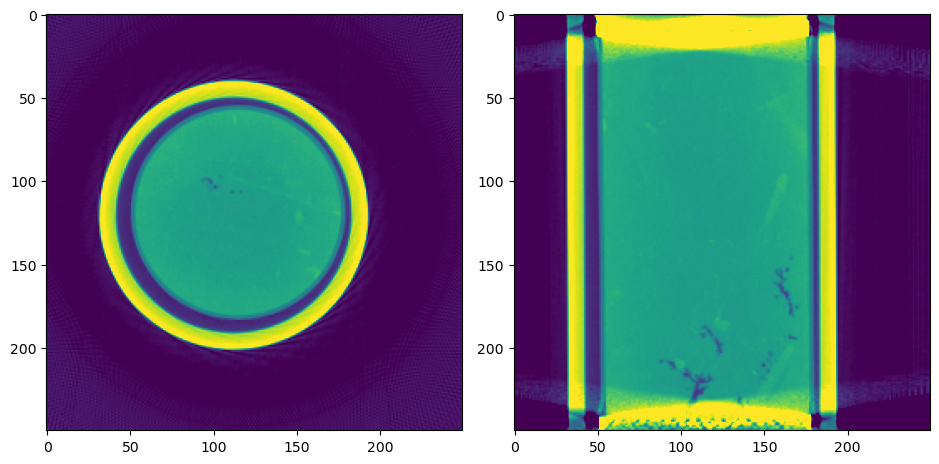

In [71]:
fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(9.5, 5))
ax[0, 0].imshow(rec[rec.shape[0]//2], cmap='viridis', vmin=0, vmax=cmax)
ax[0, 1].imshow(rec[:, rec.shape[1]//2], cmap='viridis', vmin=0, vmax=cmax)
fig.tight_layout()